## Furnace CGAN colorization

source: https://www.kaggle.com/code/pushkar007/image-colorisation-with-gans

In [84]:


class Config:
    external_data_size = 615    
    train_size = 492              
    image_size_1 = 256            ## 1400
    image_size_2 = 256            ## 390
    batch_size = 32
    LeakyReLU_slope = 0.2
    dropout = 0.5
    kernel_size = 4
    stride = 2
    padding = 1
    gen_lr = 2e-4
    disc_lr = 2e-4
    beta1 = 0.5
    beta2 = 0.999
    lambda_l1 = 100
    gan_mode = 'vanilla'
    layers_to_cut = -2
    epochs = 20
    pretrain_lr = 1e-4
    original_height = 1400
    original_width  = 390



In [46]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
Path.ls = lambda x: list(x.iterdir())

import PIL
from PIL import Image

import torch
from torch import nn, optim
from torch import nn, optim
from torchvision import transforms
from torchvision.models.resnet import resnet18
from torchvision.models.vgg import vgg19
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.hub import load_state_dict_from_url

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:


try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url



In [48]:
from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet
from fastai.data.external import untar_data, URLs

In [49]:
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [50]:
coco_path

'/home/maquina1/.fastai/data/coco_sample/train_sample'

In [51]:
civs_path = '/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs'

In [52]:
civs_path

'/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs'

In [53]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"
    
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


In [54]:
path = civs_path

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names

print(len(paths))
np.random.seed(123)
paths_subset = np.random.choice(paths, 615, replace=False) # choosing 493 images randomly
rand_idxs = np.random.permutation(615)

train_idxs = rand_idxs[:492] # choosing the first 492 as training set
val_idxs   = rand_idxs[492:] # choosing last 123 as validation set

train_paths = paths_subset[train_idxs]
val_paths   = paths_subset[val_idxs]

print(len(train_paths), len(val_paths))


615
492 123


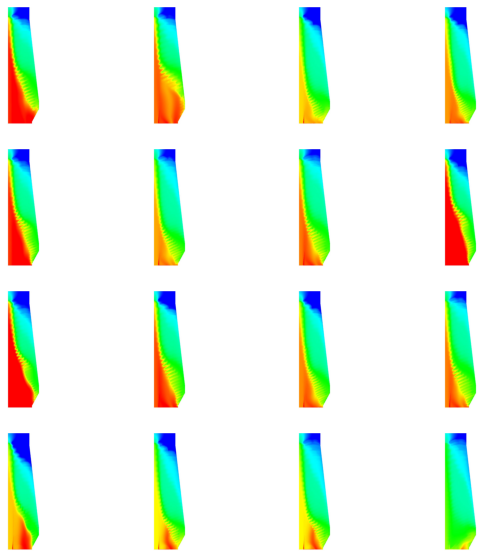

In [55]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))

for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

## Making Datasets and DataLoaders

In [56]:


SIZE = 256

class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
                                
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)



In [57]:

# A handy function to make our dataloaders

def make_dataloaders(batch_size=16, n_workers=2, pin_memory=True, **kwargs): 
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            num_workers=n_workers,
                            pin_memory=pin_memory
                           )
    return dataloader



In [58]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl   = make_dataloaders(paths=val_paths,   split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
31 8


## Generator proposed by the paper

In [59]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [60]:
class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

## Discriminator

In [61]:


class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        
        
        # the 'if' statement is taking care of not using
        # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] 
          
            
        # Make sure to not use normalization or
        # activation for the last layer of the model    
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] 
        
        self.model = nn.Sequential(*model)                                                   
        
    # when needing to make some repeatitive blocks of layers,
    # it's always helpful to make a separate method for that purpose
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): 
        
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          
        
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)



In [62]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [63]:

discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape


torch.Size([16, 1, 30, 30])

In [64]:


class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss



## Model Initialization

In [65]:


def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model



## Putting everything together

In [66]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L  = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

## Utility functions

In [68]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [69]:

## Function that helps build the generator backbone using another pretrained model 
## trained on imagenet for image classification
    
def build_backbone_unet(input_channels=1, output_channels=2, size=Config.image_size_1):
  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body   = create_body(resnet18, pretrained=True, n_in=input_channels, cut=Config.layers_to_cut)
    generator = DynamicUnet(body, output_channels, (size, size)).to(device)
    return generator




In [70]:

## Function to pretrain the generator in a supervised manner on the colorization task using L1 Loss.


def pretrain_generator(generator, train_dl, opt, criterion, epochs):
 
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = generator(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

## Training function

In [73]:
def train_model(model, train_dl, epochs, display_every=20):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intervals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 1/20
L1 Loss: 0.22042


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 2/20
L1 Loss: 0.06881


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3/20
L1 Loss: 0.04234


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4/20
L1 Loss: 0.03599


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5/20
L1 Loss: 0.03372


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6/20
L1 Loss: 0.02936


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7/20
L1 Loss: 0.02955


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8/20
L1 Loss: 0.02997


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9/20
L1 Loss: 0.02396


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10/20
L1 Loss: 0.02146


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11/20
L1 Loss: 0.02176


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12/20
L1 Loss: 0.02379


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13/20
L1 Loss: 0.02345


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14/20
L1 Loss: 0.02098


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15/20
L1 Loss: 0.01955


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 16/20
L1 Loss: 0.02233


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 17/20
L1 Loss: 0.02179


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 18/20
L1 Loss: 0.01898


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 19/20
L1 Loss: 0.01560


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 20/20
L1 Loss: 0.01546
model initialized with norm initialization


  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 1/20
Iteration 20/31
loss_D_fake: 0.81340
loss_D_real: 0.77256
loss_D: 0.79298
loss_G_GAN: 0.97259
loss_G_L1: 21.84971
loss_G: 22.82230


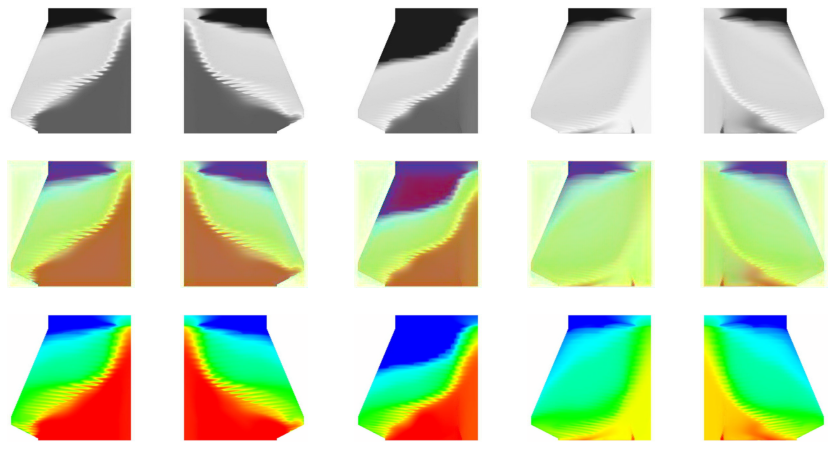

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 2/20
Iteration 20/31
loss_D_fake: 0.70227
loss_D_real: 0.69397
loss_D: 0.69812
loss_G_GAN: 0.81429
loss_G_L1: 8.68276
loss_G: 9.49705


/home/maquina1/anaconda3/envs/fastaiTorch/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


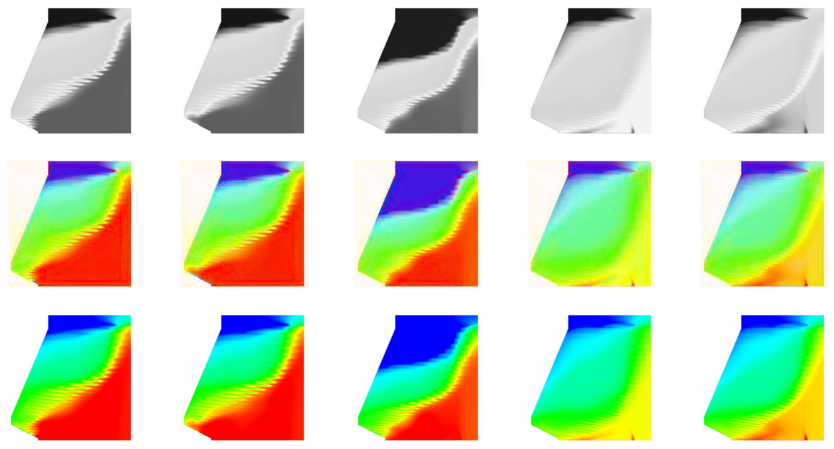

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 3/20
Iteration 20/31
loss_D_fake: 0.69009
loss_D_real: 0.69407
loss_D: 0.69208
loss_G_GAN: 0.79150
loss_G_L1: 6.91190
loss_G: 7.70340


/home/maquina1/anaconda3/envs/fastaiTorch/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)


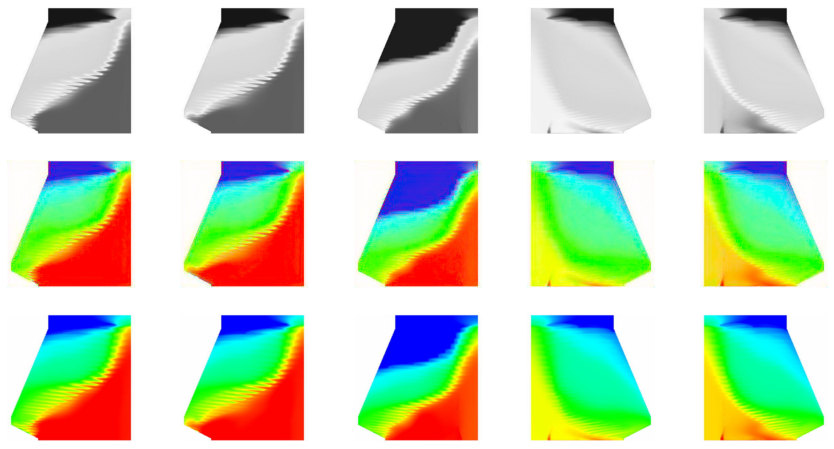

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 4/20
Iteration 20/31
loss_D_fake: 0.69345
loss_D_real: 0.69258
loss_D: 0.69301
loss_G_GAN: 0.78224
loss_G_L1: 5.52093
loss_G: 6.30317


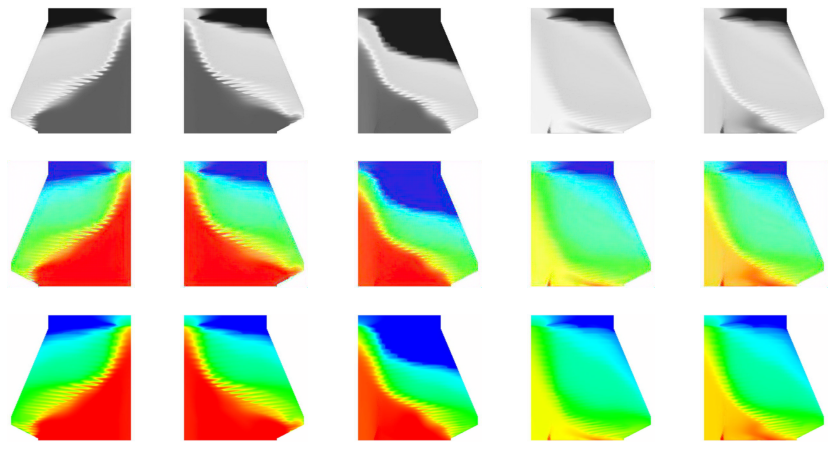

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 5/20
Iteration 20/31
loss_D_fake: 0.69555
loss_D_real: 0.69011
loss_D: 0.69283
loss_G_GAN: 0.76662
loss_G_L1: 5.18417
loss_G: 5.95079


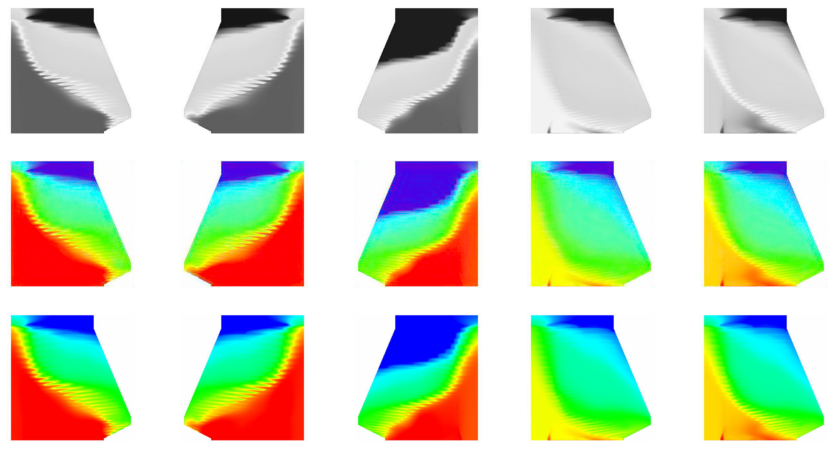

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 6/20
Iteration 20/31
loss_D_fake: 0.69942
loss_D_real: 0.69141
loss_D: 0.69542
loss_G_GAN: 0.75764
loss_G_L1: 4.20275
loss_G: 4.96040


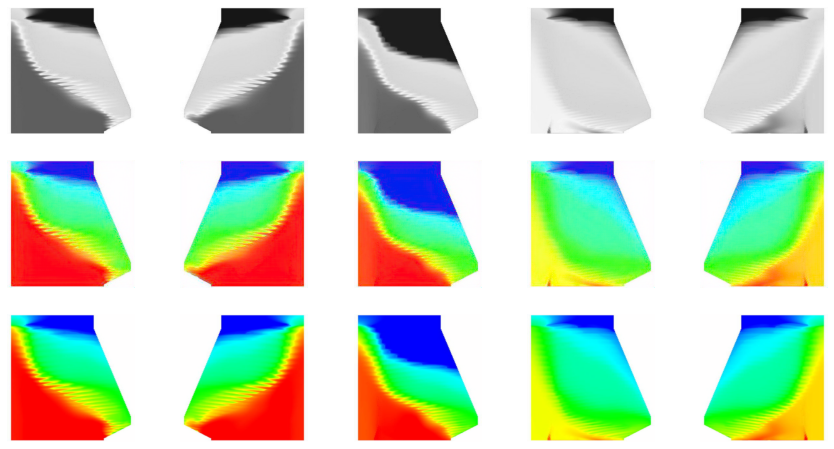

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 7/20
Iteration 20/31
loss_D_fake: 0.69177
loss_D_real: 0.68878
loss_D: 0.69027
loss_G_GAN: 0.76892
loss_G_L1: 4.06356
loss_G: 4.83248


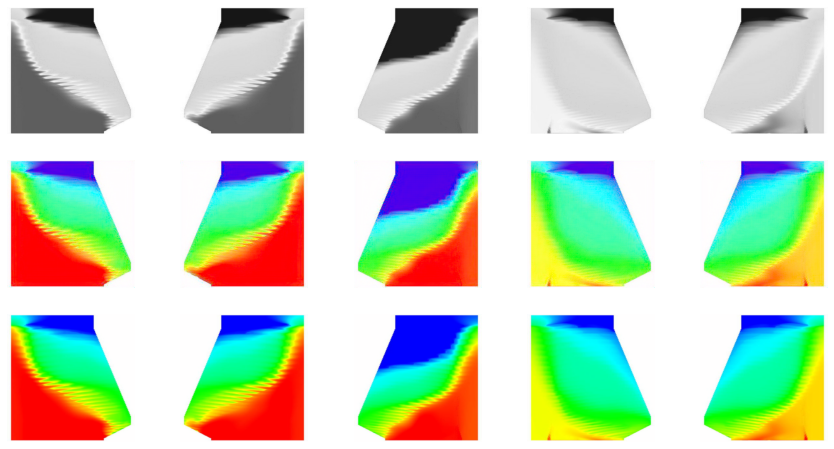

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 8/20
Iteration 20/31
loss_D_fake: 0.68663
loss_D_real: 0.68466
loss_D: 0.68564
loss_G_GAN: 0.76937
loss_G_L1: 4.04050
loss_G: 4.80987


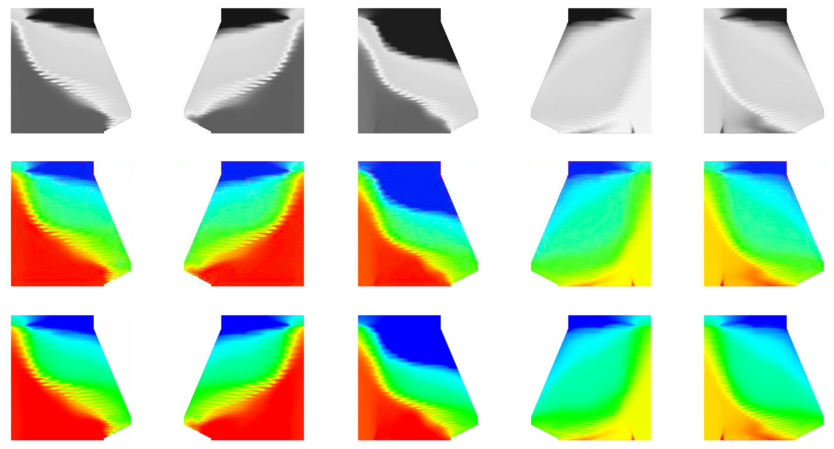

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 9/20
Iteration 20/31
loss_D_fake: 0.69185
loss_D_real: 0.68765
loss_D: 0.68975
loss_G_GAN: 0.75165
loss_G_L1: 3.88529
loss_G: 4.63693


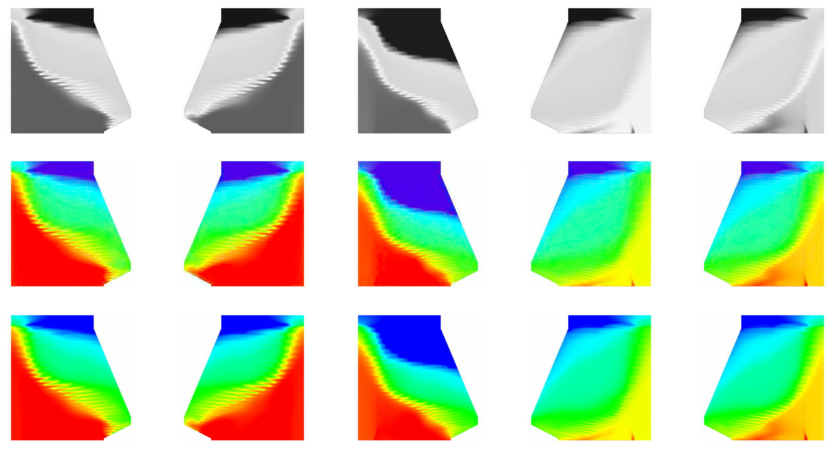

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 10/20
Iteration 20/31
loss_D_fake: 0.69002
loss_D_real: 0.68945
loss_D: 0.68973
loss_G_GAN: 0.76586
loss_G_L1: 3.66526
loss_G: 4.43112


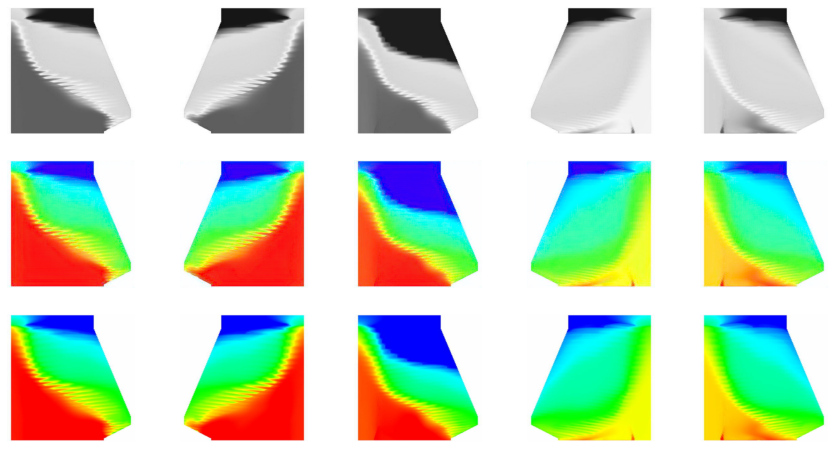

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 11/20
Iteration 20/31
loss_D_fake: 0.69370
loss_D_real: 0.69672
loss_D: 0.69521
loss_G_GAN: 0.75444
loss_G_L1: 3.49750
loss_G: 4.25194


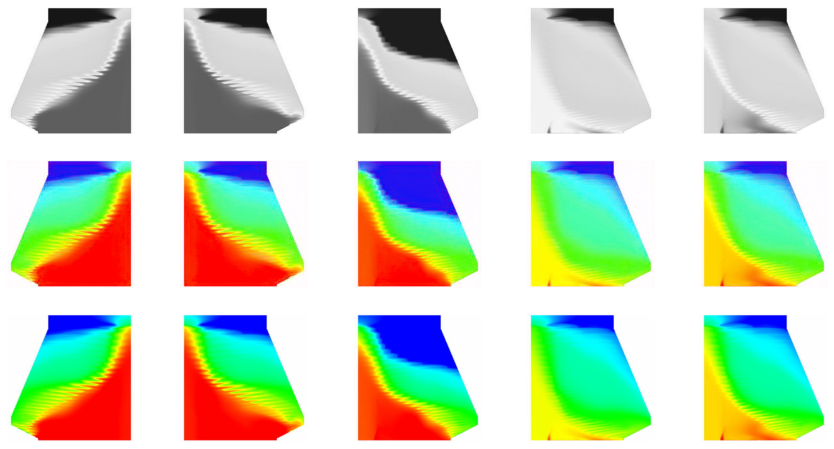

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 12/20
Iteration 20/31
loss_D_fake: 0.68256
loss_D_real: 0.68533
loss_D: 0.68395
loss_G_GAN: 0.73780
loss_G_L1: 3.24894
loss_G: 3.98674


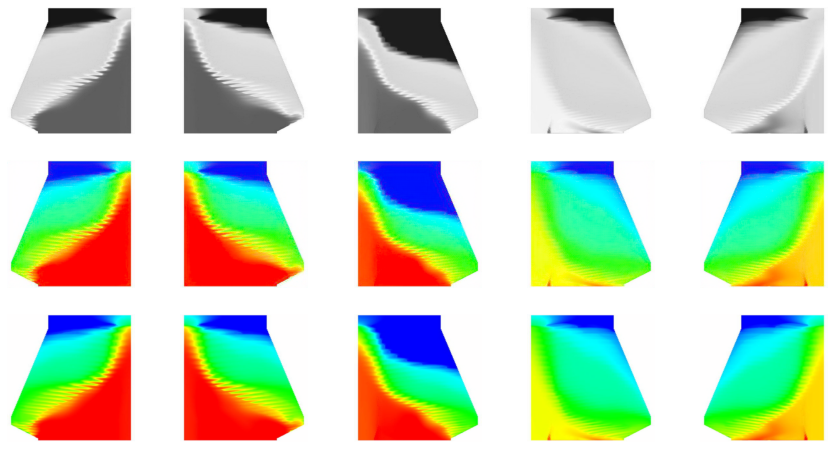

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 13/20
Iteration 20/31
loss_D_fake: 0.68772
loss_D_real: 0.68709
loss_D: 0.68741
loss_G_GAN: 0.74866
loss_G_L1: 3.00143
loss_G: 3.75009


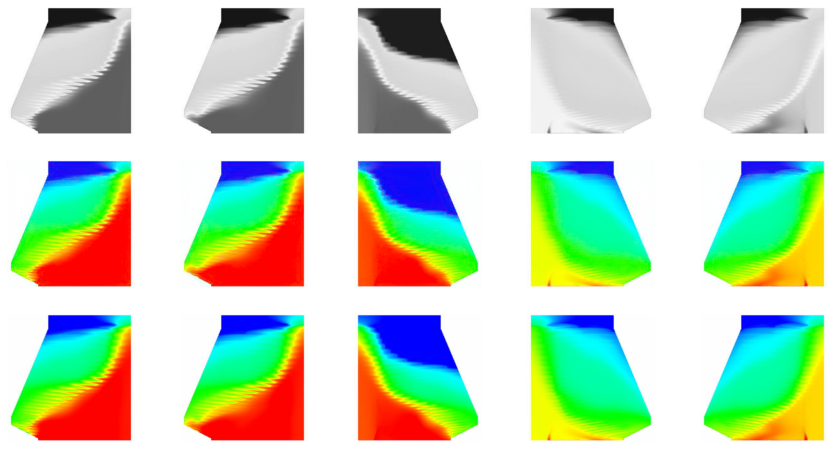

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 14/20
Iteration 20/31
loss_D_fake: 0.68698
loss_D_real: 0.68338
loss_D: 0.68518
loss_G_GAN: 0.75009
loss_G_L1: 3.10793
loss_G: 3.85801


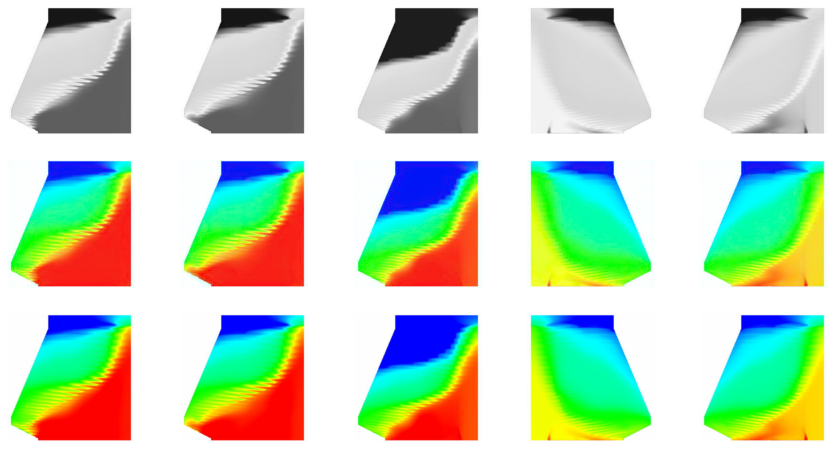

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 15/20
Iteration 20/31
loss_D_fake: 0.68541
loss_D_real: 0.69239
loss_D: 0.68890
loss_G_GAN: 0.75586
loss_G_L1: 2.93954
loss_G: 3.69541


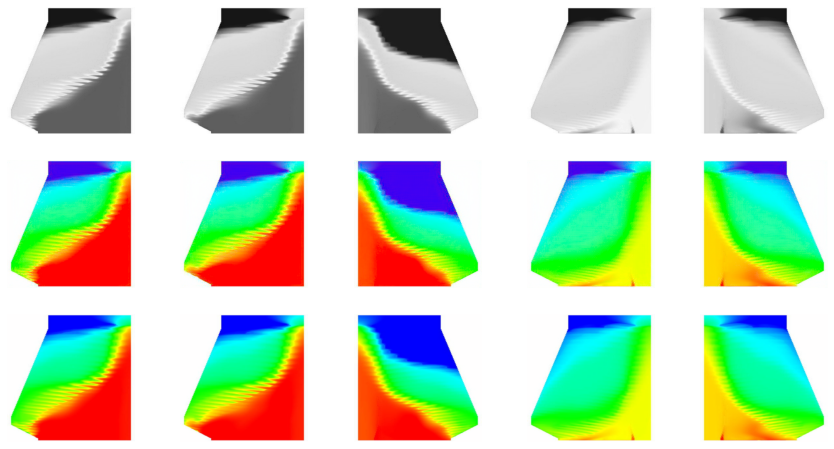

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 16/20
Iteration 20/31
loss_D_fake: 0.68547
loss_D_real: 0.68833
loss_D: 0.68690
loss_G_GAN: 0.74771
loss_G_L1: 2.80693
loss_G: 3.55464


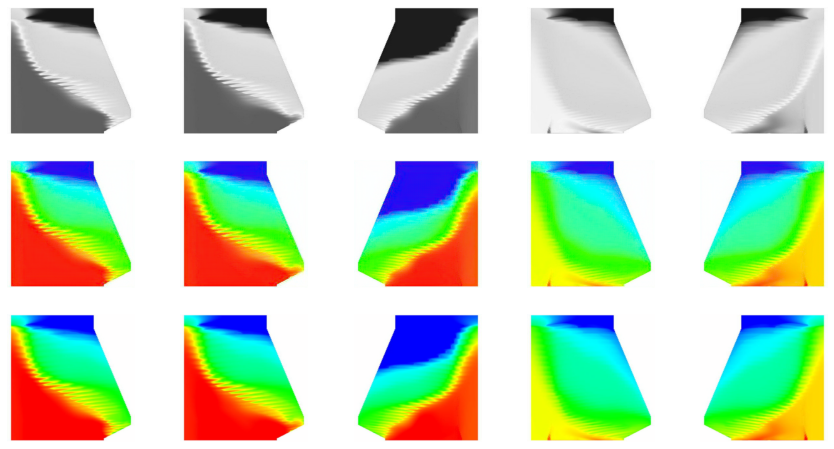

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 17/20
Iteration 20/31
loss_D_fake: 0.69098
loss_D_real: 0.68753
loss_D: 0.68925
loss_G_GAN: 0.76287
loss_G_L1: 2.98216
loss_G: 3.74503


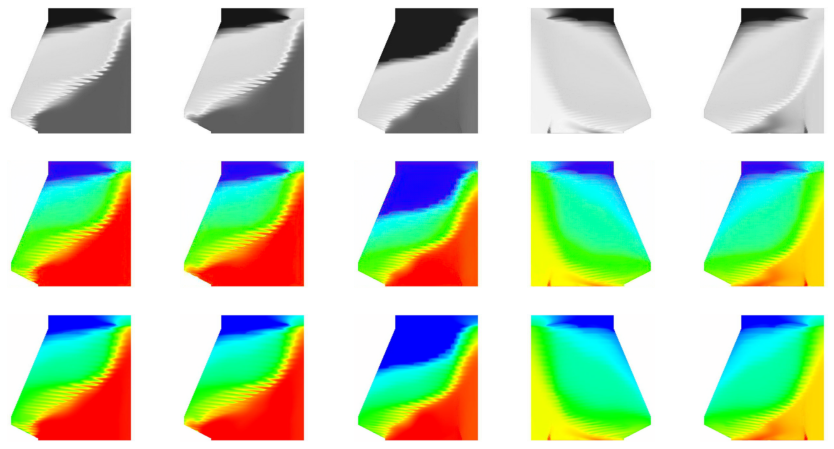

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 18/20
Iteration 20/31
loss_D_fake: 0.69878
loss_D_real: 0.70120
loss_D: 0.69999
loss_G_GAN: 0.74582
loss_G_L1: 2.94880
loss_G: 3.69462


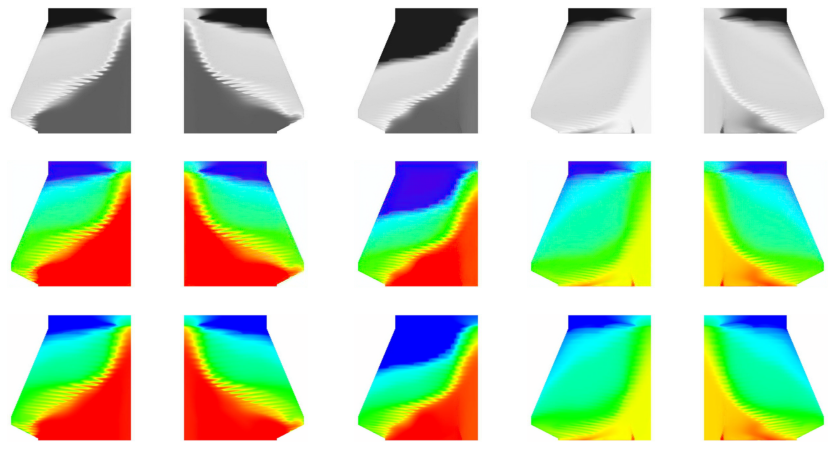

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 19/20
Iteration 20/31
loss_D_fake: 0.68946
loss_D_real: 0.68849
loss_D: 0.68898
loss_G_GAN: 0.73664
loss_G_L1: 2.46904
loss_G: 3.20568


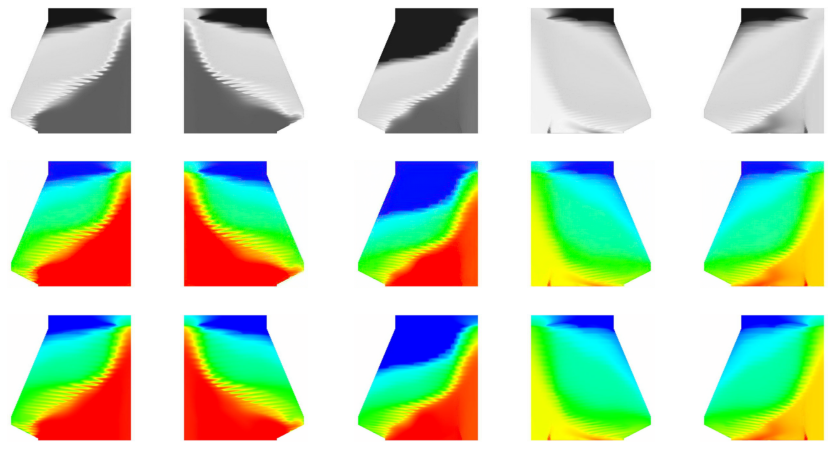

  0%|          | 0/31 [00:00<?, ?it/s]


Epoch 20/20
Iteration 20/31
loss_D_fake: 0.68885
loss_D_real: 0.68603
loss_D: 0.68744
loss_G_GAN: 0.74287
loss_G_L1: 2.67379
loss_G: 3.41666


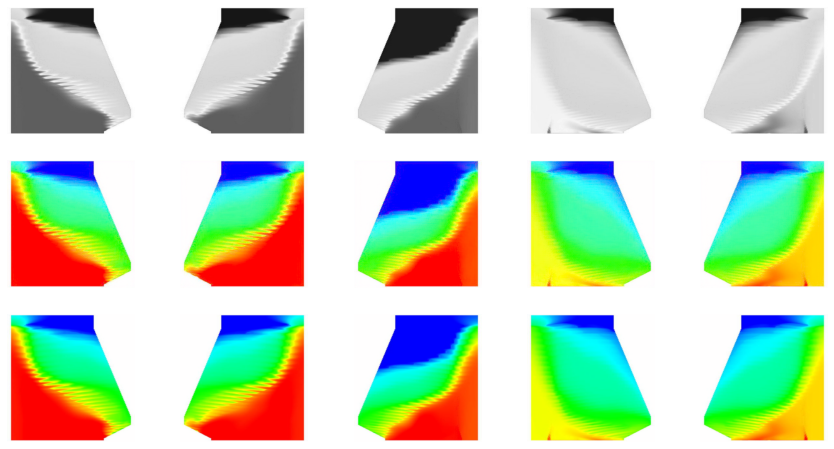

In [74]:
generator = build_backbone_unet(input_channels=1, output_channels=2, size=Config.image_size_1)
opt = optim.Adam(generator.parameters(), lr=Config.pretrain_lr)
loss = nn.L1Loss()
pretrain_generator(generator, train_dl, opt, loss, Config.epochs)
torch.save(generator.state_dict(), "res18-unet.pt")
generator.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=generator)
train_model(model, train_dl, Config.epochs)
torch.save(model.state_dict(), "main-model.pt")

## Model Inference

In [79]:
val_paths[3]

'/home/maquina1/Desktop/CIVS_DOE/furnace_imgs_CIVSDOE/data/imgs/tg_Ng150_Pci0_H0_Wp0_Ph400_Ox24_Ow6_Hbt1459.8_Wm12.2_Wr308750.4.jpg'

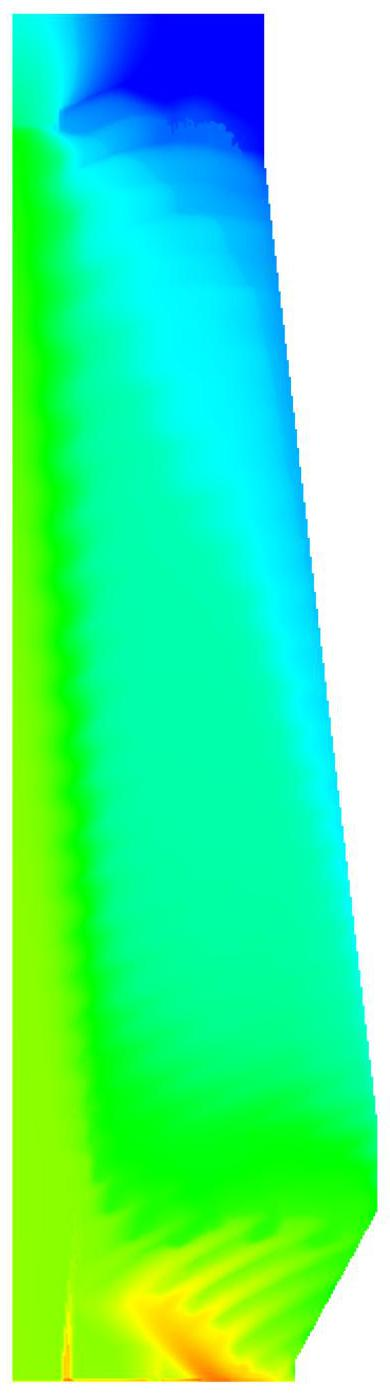

In [80]:

path = val_paths[3]
img = PIL.Image.open(path)
img


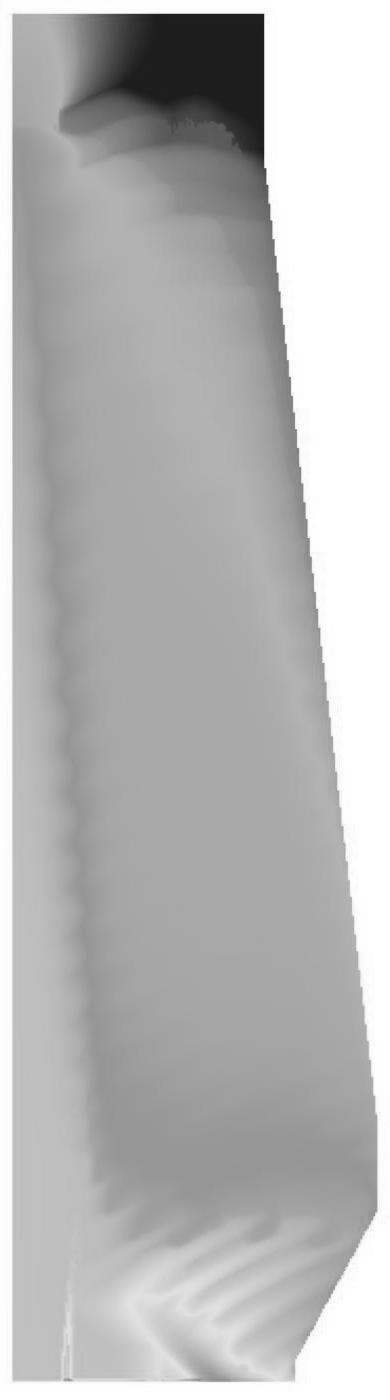

In [81]:
img = img.convert("L")
img

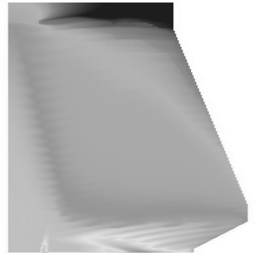

In [82]:
img = img.resize((256, 256))
img

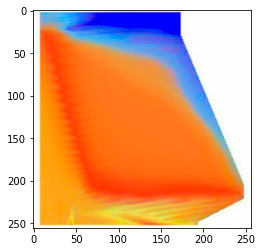

In [83]:
img = transforms.ToTensor()(img)[:1] * 2. - 1.
model.eval()

with torch.no_grad():
    preds = model.net_G(img.unsqueeze(0).to(device))
    gen_output = lab_to_rgb(img.unsqueeze(0), preds.cpu())[0]
    
# plt.imshow(img)

plt.imshow(gen_output)


In [115]:

gen_output.shape

im = Image.fromarray((gen_output * 255).astype(np.uint8))

     


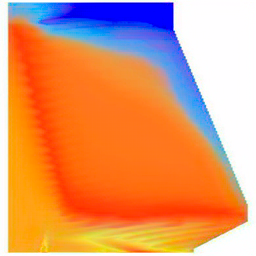

In [116]:
im

In [120]:

img = im.resize(( Config.original_width, Config.original_height))


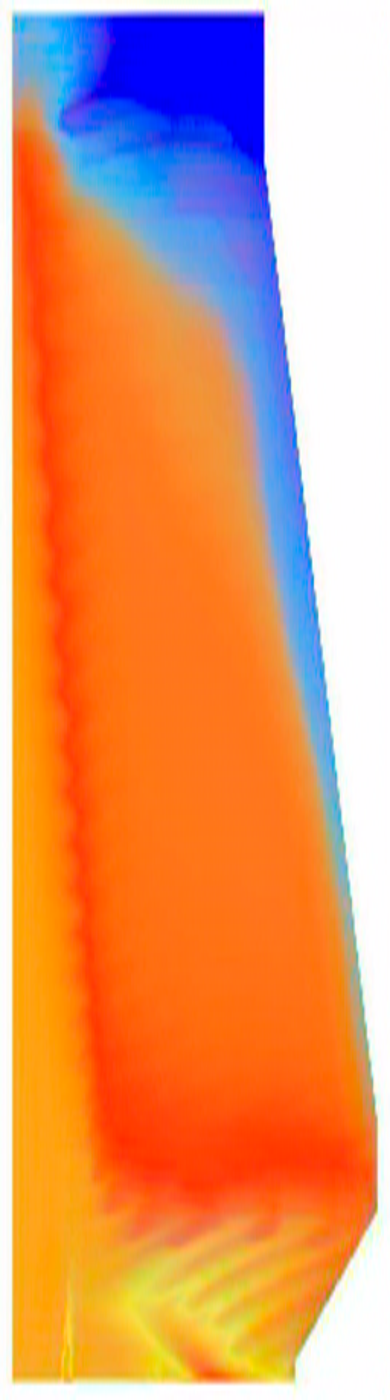

In [121]:
img